In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import cv2
import PIL
import einops
import os

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [3]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 112
WIDTH = 112

In [4]:
data_dir = pathlib.Path("./dataset/")

In [5]:
ls

 Volume in drive C has no label.
 Volume Serial Number is EC97-A748

 Directory of C:\Users\Marko\Desktop\SD_project

06/06/2025  15:01    <DIR>          .
05/06/2025  13:58    <DIR>          ..
06/06/2025  14:11    <DIR>          .ipynb_checkpoints
17/04/2025  11:32    <DIR>          dataset
06/06/2025  15:01         1.401.891 Gesture_detector.ipynb
06/06/2025  14:59         2.310.619 Gesture_detector_backup.ipynb
05/06/2025  22:00           860.086 Load_test.ipynb
06/06/2025  14:42            45.462 model.png
05/06/2025  22:16         1.898.376 model.tflite
08/04/2025  16:29         1.857.296 model_weights_1.h5
10/04/2025  16:26         1.851.920 model_weights_100epochs.h5
30/05/2025  12:19           428.306 Modello NN.docx
05/06/2025  20:21         5.553.240 my_light_model.h5
05/06/2025  22:16    <DIR>          my_model
               9 File(s)     16.207.196 bytes
               5 Dir(s)  249.301.770.240 bytes free


In [6]:
train_csv = pd.read_csv("dataset/train.csv", header=None, sep=";")
train_csv.columns = ["directory", "gesture", "label"]
train_csv.head()

,directory,gesture,label
0,WIN_20180925_17_08_43_Pro_Left_Swipe_new,Left_Swipe_new,0
1,WIN_20180925_17_18_28_Pro_Left_Swipe_new,Left_Swipe_new,0
2,WIN_20180925_17_18_56_Pro_Left_Swipe_new,Left_Swipe_new,0
3,WIN_20180925_17_19_51_Pro_Left_Swipe_new,Left_Swipe_new,0
4,WIN_20180925_17_20_14_Pro_Left_Swipe_new,Left_Swipe_new,0


In [7]:
test_csv = pd.read_csv("dataset/test.csv", header=None, sep=";")
test_csv.columns = ["directory", "gesture", "label"]
test_csv.head()

,directory,gesture,label
0,WIN_20180925_17_17_04_Pro_Left_Swipe_new,Left_Swipe_new,0
1,WIN_20180925_17_43_01_Pro_Left_Swipe_new,Left_Swipe_new,0
2,WIN_20180925_18_01_40_Pro_Left_Swipe_new,Left_Swipe_new,0
3,WIN_20180925_18_03_21_Pro_Left_Swipe_new,Left_Swipe_new,0
4,WIN_20180926_16_46_22_Pro_Left_Swipe_new,Left_Swipe_new,0


In [8]:
data_dir

WindowsPath('dataset')

In [9]:
len(list(data_dir.glob("train/*/*.png")))/30

663.0

In [10]:
data_dir.glob("train/train/*")

<generator object Path.glob at 0x000001AF601E0350>

In [11]:
train_sample = test_csv["directory"][15]
train_sample

'WIN_20180926_16_48_40_Pro_Right_Swipe_new'

In [12]:
image_sample_path = list(data_dir.glob("test/"+train_sample+"/*.png"))[0]

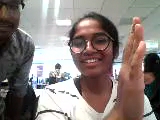

In [13]:
PIL.Image.open(str(image_sample_path))

In [14]:
img = cv2.imread(image_sample_path)
img.shape

(120, 160, 3)

In [15]:
cv2.resize(img, (HEIGHT,WIDTH)).shape

(112, 112, 3)

In [16]:
lables_dict = {
    "Left_Swipe_new": 0,
    "Right_Swipe_new": 1,
    "Stop_new": 2,
    "Thumbs_Down_new": 3,
    "Thumbs_Up_new": 4,
}

In [17]:
classes = ["Left_Swipe_new", "Right_Swipe_new", "Stop_new", "Thumbs_Down_new", "Thumbs_Up_new"]

In [18]:
immagini_cartella = list(data_dir.glob("train/"+train_csv["directory"][0]+"/*"))

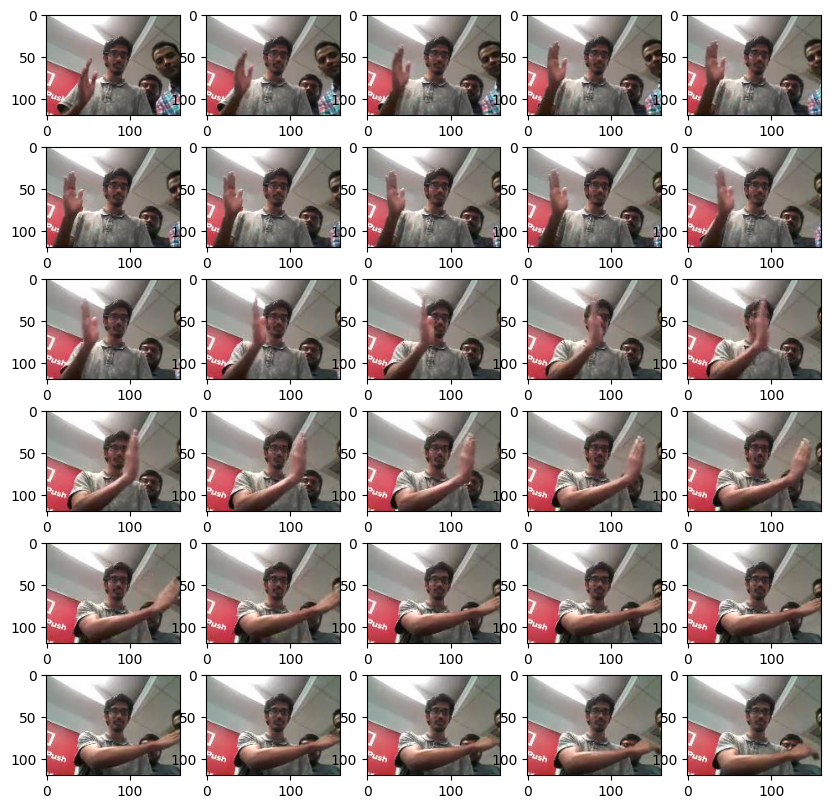

In [19]:
fig, axs = plt.subplots(6, 5, figsize=(10,10))

immagini = [PIL.Image.open(immagini_cartella[n]) for n in range(30)]
for ax, img in zip(axs.ravel(), immagini):
    ax.imshow(img)

In [20]:
def get_frames_from_dir(dir_name, out_dir="train"):
    immagini_cartella = list(data_dir.glob(out_dir+"/"+dir_name+"/*"))
    n_images = len(immagini_cartella)
    
    # reading and resizing all images from the directory
    frame_list = [cv2.resize(cv2.imread(immagini_cartella[n]), (HEIGHT,WIDTH)) for n in range(n_images)]
    return frame_list

In [21]:
a = get_frames_from_dir(train_csv["directory"][0])
b = np.array(a)
b.shape

(30, 112, 112, 3)

In [22]:
X_train = []
y_train = []

for dir_name, label in zip(train_csv["directory"], train_csv["label"]):
    y_train.append(label)
    X_train.append(get_frames_from_dir(dir_name, "train"))

In [23]:
X_test = []
y_test = []

for dir_name, label in zip(test_csv["directory"], test_csv["label"]):
    y_test.append(label)
    X_test.append(get_frames_from_dir(dir_name, "test"))

In [24]:
print("train videos: ",len(X_train))
print("train images: ",len(y_train)*30)
print("test videos: ",len(X_test))
print("test images: ",len(y_test)*30)

train videos:  663
train images:  19890
test videos:  100
test images:  3000


In [25]:
X_train_array = np.array(X_train)/255.0
X_test_array = np.array(X_test)/255.0
y_train_array = np.array(y_train)
y_test_array = np.array(y_test)

In [26]:
print(X_train_array.shape)
print(X_test_array.shape)
print(y_train_array.shape)
print(y_test_array.shape)

(663, 30, 112, 112, 3)
(100, 30, 112, 112, 3)
(663,)
(100,)


In [27]:
data_dir.glob("/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/*")

<generator object Path.glob at 0x000001AF5A9980B0>

In [28]:
arr = np.ones([2,2,3])
arr[1] = [[2,2,2],[2,2,2]]
arr

array([[[1., 1., 1.],
        [1., 1., 1.]],

       [[2., 2., 2.],
        [2., 2., 2.]]])

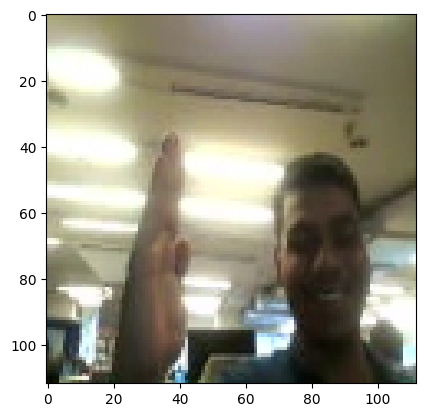

In [29]:
# openCV works with BGR and not RGB so to properly show the image we have to convert the colors first
plt.imshow(cv2.cvtColor(X_train[9][0], cv2.COLOR_BGR2RGB))

<h2>Model</h2>

In [30]:
class Conv2Plus1D(keras.layers.Layer):
    def __init__(self, filters, kernel_size, padding, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.padding = padding

        self.seq = keras.Sequential([
            layers.Conv3D(filters=filters,
                          kernel_size=(1, kernel_size[1], kernel_size[2]),
                          padding=padding),
            layers.Conv3D(filters=filters,
                          kernel_size=(kernel_size[0], 1, 1),
                          padding=padding)
        ])

    def call(self, x):
        return self.seq(x)

    def get_config(self):
        config = super().get_config()
        config.update({
            "filters": self.filters,
            "kernel_size": self.kernel_size,
            "padding": self.padding
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [31]:
class ResidualMain(keras.layers.Layer):
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

  def get_config(self):
    config = super().get_config()
    config.update({
        "filters": self.seq.layers[0].filters,
        "kernel_size": self.seq.layers[0].kernel_size,
    })
    return config

  @classmethod
  def from_config(cls, config):
      return cls(**config)

  def call(self, x):
    return self.seq(x)

In [32]:
class Project(keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__(**kwargs)
    self.units = units 
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

  def get_config(self):
    config = super().get_config()
    config.update({
        "units": self.units
    })
    return config

  @classmethod
  def from_config(cls, config):
    return cls(**config)

In [33]:
def add_residual_block(input, filters, kernel_size):
  out = ResidualMain(filters, 
                     kernel_size)(input)

  res = input
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

In [34]:
class ResizeVideo(keras.layers.Layer):
    def __init__(self, height, width, **kwargs):
        super().__init__(**kwargs)
        self.height = height
        self.width = width
        self.resizing_layer = layers.Resizing(self.height, self.width)

    def call(self, video):
        old_shape = einops.parse_shape(video, 'b t h w c')
        images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
        images = self.resizing_layer(images)
        videos = einops.rearrange(images, '(b t) h w c -> b t h w c', t=old_shape['t'])
        return videos

    def get_config(self):
        config = super().get_config()
        config.update({
            "height": self.height,
            "width": self.width
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [35]:
class TemporallyConsistentBrightness(layers.Layer):
    def __init__(self, brightness_delta_range=(-30.0, 30.0), name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.brightness_delta_range = brightness_delta_range
        self.min_delta = tf.constant(brightness_delta_range[0], dtype=tf.float32)
        self.max_delta = tf.constant(brightness_delta_range[1], dtype=tf.float32)

    def call(self, inputs, training=None):
        if training:
            inputs_float = tf.cast(inputs, tf.float32)
            batch_size = tf.shape(inputs_float)[0]

            brightness_deltas = tf.random.uniform(
                shape=(batch_size,),
                minval=self.min_delta,
                maxval=self.max_delta,
                dtype=tf.float32
            )
            broadcast_shape = tf.concat(
                [tf.shape(brightness_deltas), [1, 1, 1, 1]], axis=0
            )
            deltas_broadcast = tf.reshape(brightness_deltas, broadcast_shape)

            augmented_float = inputs_float + deltas_broadcast
            augmented_clipped = tf.clip_by_value(augmented_float, 0.0, 255.0)
            result = augmented_clipped
            return result
        else:
            return inputs

    def get_config(self):
        config = super().get_config()
        config.update({
            "brightness_delta_range": self.brightness_delta_range,
        })
        return config

In [36]:
input_shape = (None, 30, HEIGHT, WIDTH, 3)
inputs = layers.Input(shape=(input_shape[1:]))
x = inputs

x = TemporallyConsistentBrightness(brightness_delta_range=(-30.0, 30.0))(x)

x = Conv2Plus1D(filters=16, kernel_size=(3, 5, 5), padding='same')(x) # originale era (3, 7, 7)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
#x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x) # scommentare in caso

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(5)(x)
#x = layers.Dense(5, activation='softmax')(x) # aggiunta softmax finale

model = keras.Model(inputs, x)

In [37]:
#frames, label = next(iter(train_ds))
#model.build(X_train_array)

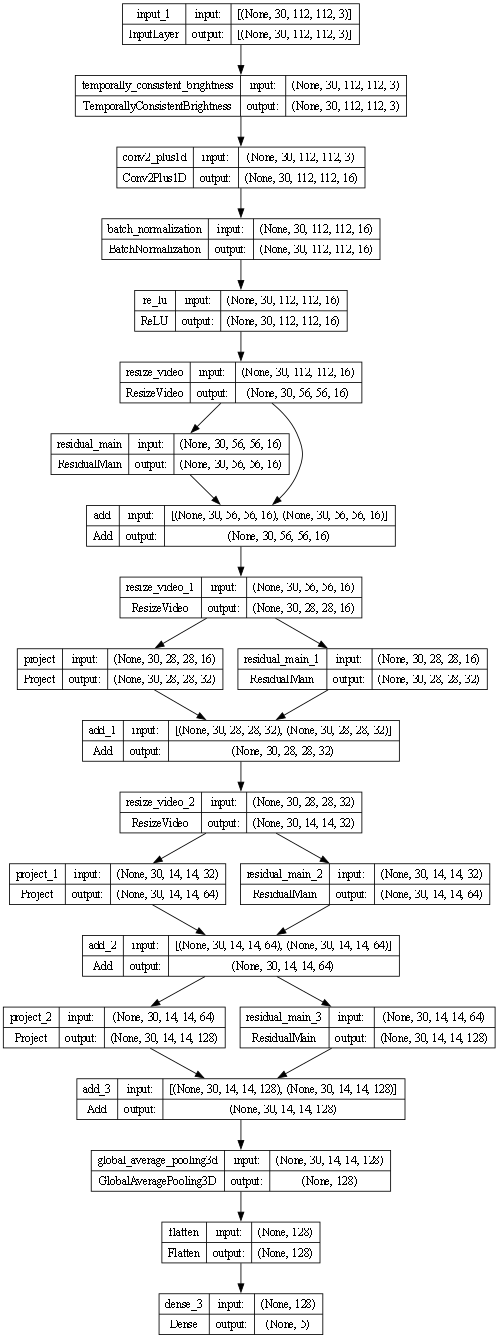

In [38]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 112, 11  0           []                               
                                2, 3)]                                                            
                                                                                                  
 temporally_consistent_brightne  (None, 30, 112, 112  0          ['input_1[0][0]']                
 ss (TemporallyConsistentBright  , 3)                                                             
 ness)                                                                                            
                                                                                                  
 conv2_plus1d (Conv2Plus1D)     (None, 30, 112, 112  2000        ['temporally_consistent_brigh

In [40]:
model.compile(loss = keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [41]:
num_classes = 5
y_train_array_categorical = to_categorical(y_train_array, num_classes=num_classes)
y_test_array_categorical = to_categorical(y_test_array, num_classes=num_classes)

In [ ]:
history = model.fit(X_train_array, y_train_array_categorical, epochs = 100)

In [ ]:
model.save("my_light_model.h5")

In [103]:
# saving the weights
# model.save_weights("model_weights_1.h5")
model.load_weights("model_weights_100epochs.h5")

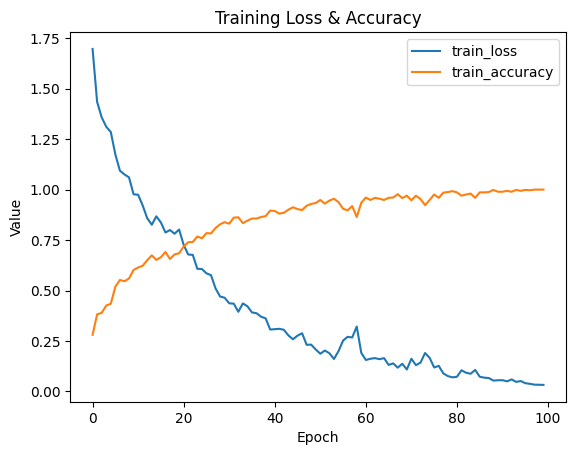

In [50]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.legend()
plt.title('Training Loss & Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()

In [51]:
model.evaluate(X_test_array, y_test_array_categorical, return_dict=True)

4/4 [==============================] - 1s 138ms/step - loss: 0.3158 - accuracy: 0.9000


{'loss': 0.3157635033130646, 'accuracy': 0.8999999761581421}

In [109]:
y_pred = [np.argmax(p) for p in model.predict(X_test_array)]

4/4 [==============================] - 2s 126ms/step


<Axes: >

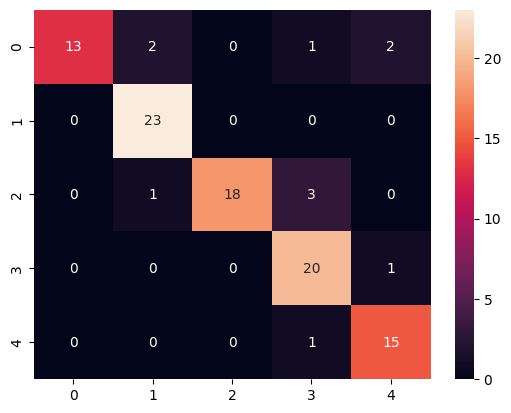

In [110]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)

In [106]:
model.save("my_model")
converter = tf.lite.TFLiteConverter.from_saved_model("my_model")
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


In [97]:
interpreter = tf.lite.Interpreter(model_path="model.tflite")
input_details = interpreter.get_input_details()
print(input_details[0]['dtype'])

<class 'numpy.float32'>
